<a href="https://colab.research.google.com/github/dfrey/MyCode/blob/master/NN_based_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic recommender


In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q jinja2

In [4]:
pip install tensorflow_recommenders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install tensorflow-datasets


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from typing import Dict, Text

import os
import pprint
import tempfile

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

### Read the data

In [2]:
ratings_full = tfds.load('movielens/100k-ratings', split="train")

user_ids = ratings_full.map(lambda x: x["user_id"])
unique_user_ids = np.unique(list(tfds.as_numpy(user_ids)))

movie_titles = ratings_full.map(lambda x: x["movie_title"])
unique_movie_titles = np.unique(list(tfds.as_numpy(movie_titles)))

c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:02<00:00,  1.69s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:02<00:00,  2.20s/ url]


Dataset movielens downloaded and prepared to C:\Users\LENOVO PC\tensorflow_datasets\movielens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


> ### TODO
>
> Display the ten first examples to explore the list of available informations
>
> Usefull: `Dataset.take(count)`, `tfds.as_numpy()`, `tfds.as_dataframe()`

In [14]:
# Prendre les 10 premiers exemples du dataset
ratings_preview = ratings_full.take(10)

# Convertir en dataframe
df_preview = tfds.as_dataframe(ratings_preview)

# Afficher les 10 premiers exemples sous forme de dataframe
df_preview.head(10)


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'
5,18.0,"[7, 16]",b'325',b'Crash (1996)',19.0,876346551,False,b'601',1,b'artist',4.0,b'99687'
6,18.0,"[2, 3, 4, 12]",b'95',b'Aladdin (1992)',19.0,882064434,True,b'710',17,b'student',3.0,b'92020'
7,25.0,"[0, 5, 14]",b'92',b'True Romance (1993)',34.0,875135363,True,b'833',21,b'writer',2.0,b'90019'
8,25.0,[4],b'425',b'Bob Roberts (1992)',27.0,880844102,True,b'916',18,b'engineer',5.0,b'N2L5N'
9,25.0,"[0, 1, 15, 18]",b'271',b'Starship Troopers (1997)',32.0,884801053,True,b'940',2,b'administrator',2.0,b'02215'


In [7]:
print(unique_user_ids.size)
print(unique_movie_titles.size)
print(ratings_full.cardinality().numpy()/(unique_user_ids.size*unique_movie_titles.size))
# TODO add your code here


943
1664
0.06372868912635615


Restrict the dataset to used features.

In [17]:
# Ratings data.
ratings = ratings_full.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"],
})

ratings

<CacheDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Split the data into a training set and a testing set.

In [18]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Define a model

We can define a prediction model by inheriting from `tf.keras.Model` and implementing the `call` method.

> ### TODO
>
> Draw the model (you can draw it on a piece of paper and scan it, or take a picture of it, and include your picture in the zip file you submit. You should name your file either `[lastname1]-[lastname2]-modeldrawing.jpg/pdf/...` or `[firstname]-[lastname]-modeldrawing.jpg/pdf/...` depending on whether you worked in pairs or alone. 

In [10]:
class DotRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.layers.Dot(axes=(1))

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings((user_embedding, movie_embedding))

In [20]:

# Keras2
#DotRankingModel()({"user_id": ["42","42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)", "Strictly Ballroom (1992)"]})

# version for Keras 3
user_ids_input = tf.constant(["42", "42"])
movie_titles_input = tf.constant(["One Flew Over the Cuckoo's Nest (1975)", "Strictly Ballroom (1992)"])

# Pass the tensors in the dict.
DotRankingModel()({"user_id": user_ids_input, "movie_title": movie_titles_input})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00160515],
       [-0.00140406]], dtype=float32)>

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method.

> ### TODO
>
> Explain the role played by this model
>
La classe `tfrs.Model` est une classe de base pour construire des modèles de recommandation avec TensorFlow Recommenders. Elle facilite la création de systèmes de recommandation en gérant les embeddings des utilisateurs et des éléments, ainsi que le calcul de la perte.

La méthode `compute_loss` calcule la différence entre les prédictions du modèle et les valeurs réelles (par exemple, les évaluations), ce qui permet de mesurer l'erreur du modèle. Cette erreur est utilisée pour ajuster les paramètres du modèle (embeddings) pendant l'entraînement, en minimisant la perte.

In [34]:
class MovieLensModel(tfrs.models.Model):

  def __init__(self, rating_model: tf.keras.Model):
    super().__init__()
    self.ranking_model = rating_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(features)

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.get("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

## Fit and test the model

In [35]:
# Create a retrieval model.
model = MovieLensModel(DotRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
dot_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = dot_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10


c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'movie_lens_model_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 13.6816 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.7075 - total_loss: 13.6816 - val_loss: 13.7412 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 3.7071 - val_total_loss: 13.7412
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.7090 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.7049 - total_loss: 13.7090 - val_loss: 13.7412 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 3.7071 - val_total_loss: 13.7412
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7467 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.7075 - total_loss: 13.7467 - val_loss: 13.7412 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 3.7071 - val_total_loss: 13.7412
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7207 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.7077 - total_loss: 13.7207 - val_loss: 13.7412 

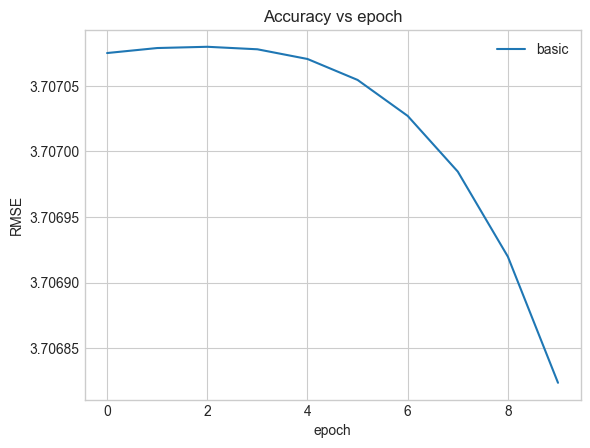

In [54]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

> ### TODO
>
> Comment the curve

# 📊 Analyse du Graphique RMSE vs Epochs

## 📌 Observations

- **Époques 0-3** : Le RMSE stagne légèrement, suggérant que le modèle peine à apprendre au début.
- **Époques 4-9** : Le RMSE diminue progressivement, indiquant une meilleure adaptation du modèle aux données.
- **Tendance générale** : L'erreur baisse continuellement, mais une vérification de l'overfitting est nécessaire.

## 🔎 Interprétation

- Une diminution du RMSE est positive, mais ne garantit pas des recommandations pertinentes.
- Compléter cette analyse avec des métriques comme **NDCG, MAP ou HR@K** est essentiel.
- Si le RMSE continue de baisser fortement, un risque de sur-apprentissage doit être surveillé.


## 🏁 Conclusion

Le modèle apprend progressivement mais pourrait être optimisé pour de meilleures recommandations. Une analyse plus poussée avec des métriques adaptées est nécessaire avant de valider la performance.


> ### TODO
> Can you make the model more accurate? How?

## Optimisation du Modèle de Recommandation

Voici trois méthodes pour améliorer la précision du modèle de recommandation :

### 1. **Ajustement des Hyperparamètres**
   - **Taux d'apprentissage** : Tester différents taux d'apprentissage pour trouver la valeur qui permet une convergence rapide tout en évitant la divergence. Des valeurs typiques à explorer sont 0.01, 0.001, ou 0.0001.
   - **Optimiseur** : Remplacer l'optimiseur utilisé (par exemple **Adagrad**) par d'autres plus robustes comme **Adam** ou **RMSprop**, qui sont souvent plus performants pour la convergence, surtout dans des tâches complexes comme la recommandation.

### 2. **Ajout de Métadonnées sur les Films et Utilisateurs**
   - **Métadonnées sur les Films** : Ajouter des informations supplémentaires sur les films, comme leur genre, année de production, acteurs principaux, ou durée. Ces données peuvent enrichir la compréhension du modèle sur les films et améliorer les recommandations.
   - **Métadonnées sur les Utilisateurs** : Ajouter des informations utilisateur comme l'âge, les préférences de visionnage ou l'historique des interactions. Ces métadonnées permettent de mieux personnaliser les recommandations en fonction des caractéristiques spécifiques de chaque utilisateur.

### 3. **Évaluation Top-K**
   - **Top-K Evaluation** : Au lieu de se concentrer uniquement sur la précision globale, utiliser des métriques comme la **précision top-K** ou le **rappel top-K** pour évaluer la pertinence des recommandations parmi les K premiers articles proposés. Cela permet de mieux comprendre si les premières recommandations sont réellement utiles pour les utilisateurs.

Ces trois méthodes permettent d'améliorer la précision des recommandations en affinant les paramètres du modèle, en ajoutant plus de contexte grâce aux métadonnées, et en utilisant des métriques d'évaluation adaptées pour mesurer la qualité des recommandations les plus pertinentes.


# More complex link between user's and item's representations

Let replace the dot product between user's and item's representations by a fully connected layer of size 64, followed by a fully connected layer with a unique output.

> ### TODO
>
> - Define the layer and adapt the `call` method
> - Choose carefully the activation functions of the layers
>
> Useful: `tf.keras.Sequential`, `tf.keras.Dense`, `tf.concat`
> 
> You can alo checkout the Tensorflow/Keras tutorial here https://www.tensorflow.org/guide/keras/sequential_model

In [58]:
class OneLayerRankingModel(tf.keras.Model):
    
  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # More complex link between user's and item's representations
    # Define a fully connected layer of size 64, followed by a unique output
    self.dense_1 = tf.keras.layers.Dense(64, activation='relu')  # First dense layer with 64 units and ReLU activation
    self.dense_2 = tf.keras.layers.Dense(1)  # Output layer with a single unit (no activation)

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    # Get embeddings for users and movies
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    # Concatenate the user and movie embeddings to create a combined representation
    combined_representation = tf.concat([user_embedding, movie_embedding], axis=1)

    # Pass the combined representation through the dense layers
    x = self.dense_1(combined_representation)  # First dense layer
    prediction = self.dense_2(x)  # Second dense layer to get the prediction

    return prediction

In [59]:
import tensorflow as tf

# Exemple de données
user_ids = ["42"]
movie_titles = ["One Flew Over the Cuckoo's Nest (1975)"]

# Convertir les données en tenseurs
inputs = {
    "user_id": tf.convert_to_tensor(user_ids, dtype=tf.string),
    "movie_title": tf.convert_to_tensor(movie_titles, dtype=tf.string)
}

# Instancier et appeler le modèle
model = OneLayerRankingModel()
prediction = model(inputs)

print(prediction)


tf.Tensor([[-0.00314073]], shape=(1, 1), dtype=float32)


In [ ]:
 # OneLayerRankingModel()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"]})

In [61]:
# Create a retrieval model.
model = MovieLensModel(OneLayerRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
one_layer_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = one_layer_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10


c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'movie_lens_model_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.8558 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.8130 - total_loss: 1.8558 - val_loss: 1.1427 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 1.0794 - val_total_loss: 1.1427
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0676 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.0571 - total_loss: 1.0676 - val_loss: 0.9904 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 1.0014 - val_total_loss: 0.9904
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9548 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 0.9829 - total_loss: 0.9548 - val_loss: 0.9405 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 0.9756 - val_total_loss: 0.9405
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9049 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 0.9570 - total_loss: 0.9049 - val_loss: 0.9276 - val_regulariz

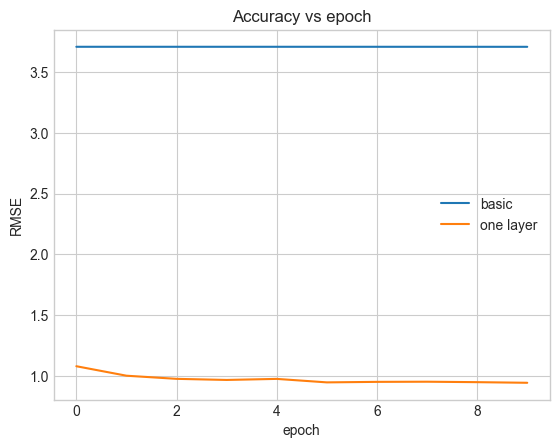

In [62]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# Taking advantage of context features

Let use timestamps of the ratings and movie titles to enrich the input of the model.

Some preliminary:

In [64]:
timestamps = np.concatenate(list(ratings_full.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

New user model.

> ### TODO
>
> Draw and explain the role played by the components of the model



### Composants du Modèle et Leur Rôle

#### 1.1 **Embeddings des Utilisateurs**
- **Description :** Ce sont des vecteurs (représentations numériques) qui capturent les préférences d'un utilisateur dans un espace de caractéristiques.
- **Rôle :** Ils permettent de représenter un utilisateur de manière compacte. Lorsqu'un utilisateur interagit avec le système (par exemple, en évaluant des films), son embedding est mis à jour pour mieux correspondre à ses goûts.

#### 1.2 **Embeddings des Films (Items)**
- **Description :** Ce sont aussi des vecteurs qui représentent les films ou articles dans un espace de caractéristiques.
- **Rôle :** Ces embeddings capturent les caractéristiques d'un film, comme le genre, la popularité ou les attributs qui influencent les choix des utilisateurs. L’objectif est de donner une représentation numérique de chaque film.

#### 1.3 **Couche de Prédiction (Produit Scalaire ou MLP)**
- **Description :** Il s'agit de la partie du modèle qui calcule la prédiction. Soit un produit scalaire entre les embeddings de l'utilisateur et du film, soit une couche entièrement connectée (MLP) qui apprend une relation non linéaire entre les deux embeddings.
- **Rôle :** Cela permet de prédire la note qu'un utilisateur donnerait à un film en fonction de ses préférences et des caractéristiques du film. Le produit scalaire est une estimation simple, tandis que l'MLP peut capturer des interactions plus complexes.

#### 1.4 **Mécanisme pour les Utilisateurs Nouveaux (Cold Start)**
- **Description :** Les utilisateurs qui n'ont pas encore d'historique d'interaction avec le système. Pour ces utilisateurs, des embeddings par défaut ou des informations supplémentaires comme des métadonnées (âge, sexe) peuvent être utilisées pour générer des prédictions.
- **Rôle :** Permet de traiter les utilisateurs froids (sans historique) et de faire des recommandations pertinentes dès le début. Les embeddings de ces utilisateurs sont ajustés au fur et à mesure qu'ils interagissent avec le système.

---

### Schéma du Modèle

Voici un schéma simple pour visualiser le modèle :

```plaintext
[Input: user_id]  --->  [User Embedding] ---\
                                          \
[Input: movie_title] ---> [Movie Embedding] --> [Prediction Layer] --> [Predicted Rating]



In [65]:
class EnrichedRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [67]:
import tensorflow as tf

# Données d'entrée
features = {
    "user_id": tf.convert_to_tensor(["42"]),  # Convertir l'ID de l'utilisateur en un tensor
    "movie_title": tf.convert_to_tensor(["One Flew Over the Cuckoo's Nest (1975)"]),  # Convertir le titre du film en tensor
    "timestamp": tf.convert_to_tensor([879024327]),  # Convertir le timestamp en tensor
}

# Créer et appeler le modèle
model = EnrichedRankingModel()
predictions = model(features)

# Afficher les résultats
print(predictions)


tf.Tensor([[0.05344875]], shape=(1, 1), dtype=float32)


In [68]:
# Create a retrieval model.
model = MovieLensModel(EnrichedRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
enriched_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = enriched_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10


c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'movie_lens_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.8288 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.7852 - total_loss: 1.8288 - val_loss: 1.1786 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 1.0946 - val_total_loss: 1.1786
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0994 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.0635 - total_loss: 1.0994 - val_loss: 1.0399 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 1.0245 - val_total_loss: 1.0399
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9727 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 0.9976 - total_loss: 0.9727 - val_loss: 0.9570 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 0.9808 - val_total_loss: 0.9570
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.9142 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 0.9680 - total_loss: 0.9142 - val_loss: 0.9582 - val_regula

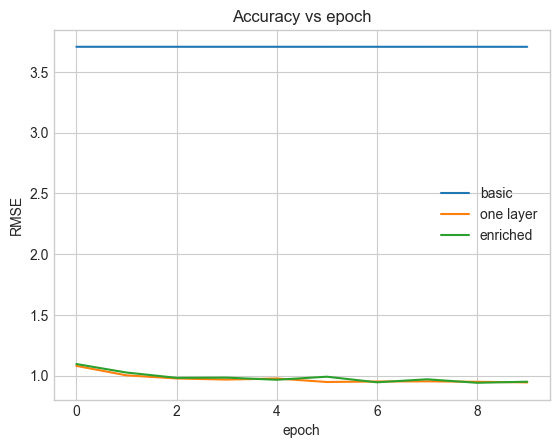

In [69]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# More comple models



> ### TODO
>
> Build and test more complex models:
> - with more layers to link user's and item's representation
> - integrating more contextual information: user's age, movie's genre, ...



# Copyright

Several section of this notebook originate from notebooks under the following copyright:

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.